# User Overview Analysis

In [17]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

In [1]:
import os
import sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

In [2]:
# import load_data from scripts module
from db_connect import load_data

xdr_df = load_data()

Connection to database successful!
Connection to database successful!


In [3]:
# Explre the first five rows
xdr_df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [4]:
# Let's check the size of the data
xdr_df.shape

(150001, 55)

In [5]:
object_columns = xdr_df.select_dtypes(include='object').columns
print(object_columns)

Index(['Start', 'End', 'Last Location Name', 'Handset Manufacturer',
       'Handset Type'],
      dtype='object')


In [6]:
# check missing data
missing_values = xdr_df.isnull().sum()

# Print columns with missing values only
missing_columns = missing_values[missing_values > 0]
print(missing_columns.reset_index())

                                       index       0
0                                  Bearer Id     991
1                                      Start       1
2                                   Start ms       1
3                                        End       1
4                                     End ms       1
5                                  Dur. (ms)       1
6                                       IMSI     570
7                              MSISDN/Number    1066
8                                       IMEI     572
9                         Last Location Name    1153
10                           Avg RTT DL (ms)   27829
11                           Avg RTT UL (ms)   27812
12                   Avg Bearer TP DL (kbps)       1
13                   Avg Bearer TP UL (kbps)       1
14               TCP DL Retrans. Vol (Bytes)   88146
15               TCP UL Retrans. Vol (Bytes)   96649
16                       DL TP < 50 Kbps (%)     754
17            50 Kbps < DL TP < 250 Kbps (%)  

Approach to Handle Missing Values:

Handling Missing Values in Key Columns

Bearer Id, IMSI, MSISDN/Number, and IMEI: These are key identifiers, and missing values here can mean lost user data. I may need to drop rows where these columns are missing, as they are essential for user-level aggregation.

Avg RTT DL/UL (ms): These are performance metrics. If missing values are frequent, I might replace them with the mean/median of their respective columns.

Throughput Metrics (DL TP and UL TP columns): Similarly, these columns can be filled with the mean or median values.

In [7]:
# Drop rows with missing IMSI, MSISDN/Number, IMEI, and Last Location Name (as they are key identifiers)
df_cleaned = xdr_df.dropna(subset=['Bearer Id', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name'])

# List of throughput-related columns that may contain NaN values
throughput_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
                      'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 
                      'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', 
                      '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)']

# Filling NaN values with the mean for each column
df_cleaned.loc[:, throughput_columns] = df_cleaned[throughput_columns].fillna(df_cleaned[throughput_columns].mean())

In [8]:
# Fill NaN values in 'Total UL (Bytes)' and 'Total DL (Bytes)' with 0
df_cleaned.loc[:, ['Total UL (Bytes)', 'Total DL (Bytes)']] = df_cleaned[['Total UL (Bytes)', 'Total DL (Bytes)']].fillna(0)


In [9]:
# Check and drop duplicates
duplicate_count = df_cleaned.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 0


In [10]:
df_cleaned.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

In [11]:
import numpy as np

# Ensure were are working on a copy of the DataFrame to avoid setting issues
df_cleaned = df_cleaned.copy()

# Select only numeric columns (exclude location and date)
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns

# Clip outliers for the numeric columns
for column in numeric_columns:
    lower_bound = df_cleaned[column].quantile(0.05)
    upper_bound = df_cleaned[column].quantile(0.95)
    df_cleaned.loc[:, column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)

In [12]:
# Convert 'Start' column to datetime format
import pandas as pd
df_cleaned['Start'] = pd.to_datetime(df_cleaned['Start'], format='%m/%d/%Y %H:%M')

In [13]:
# Check data type of 'Start' column
print(df_cleaned['Start'].dtype)

datetime64[ns]


In [14]:
from handset_analysis import HandsetAnalysis

ha = HandsetAnalysis(df_cleaned)
# top 10 handsets
top_10 = ha.top_handsets(top_n=10).reset_index()

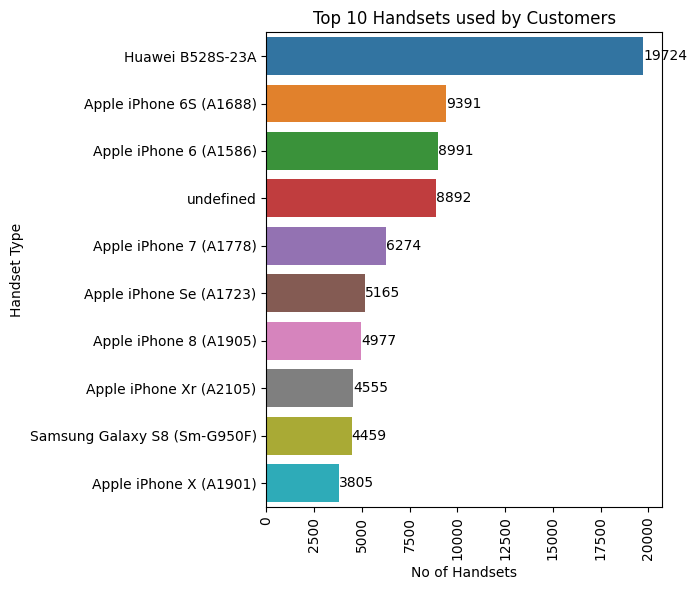

In [18]:
# Bar Plot of top 10 bandsets
plt.figure(figsize=(7, 6))
barplot = sn.barplot(x='count', y='Handset Type', data=top_10, hue='Handset Type')

# Add counts on the end of each bar
for index, value in enumerate(top_10['count']):
    barplot.text(value, index, f'{value}', va='center', ha='left', color='black')

# Rotate x-axis labels to 90 degrees
plt.xticks(rotation=90)

plt.title('Top 10 Handsets used by Customers')
plt.ylabel('Handset Type')
plt.xlabel('No of Handsets')
plt.tight_layout()
plt.show()

In [19]:
# Top 3 manufactures
print('Top 3 Manufacturers')
top_3_manufacturers = ha.top_manufacturers(top_n=3).reset_index(name='no_of_manufacturer')
top_3 = top_3_manufacturers.reset_index(drop=True)

Top 3 Manufacturers


In [20]:
top_3

,Handset Manufacturer,no_of_manufacturer
0,Apple,59304
1,Samsung,40393
2,Huawei,34269
